In [1]:
import numpy as np
import pandas as pd
from scipy.special import comb as nchoosek
import os
import tqdm.notebook as tqdm

from natvar.helpers import gene_seq_to_array

In [2]:
DATDIR = "../data"
RESULTS_DIR = "../results"

In [3]:
NGENES = 107  # Number of genes
NRESULT_FILES = 86  # Number of result files
QUERY_LENGTH = 30
NGENOMES = (NRESULT_FILES - 1) * 1000 + 608
GENOME_LENGTH = 4.6 * 1E6

mq_results_0_dir = f"{RESULTS_DIR}/multiquery_results_0_30"
mq_results_1_dir = f"{RESULTS_DIR}/multiquery_results_130_160"

query_list_fpath_0 = f"{DATDIR}/query_list_0_30.txt"
query_list_fpath_1 = f"{DATDIR}/query_list_130_160.txt"

wtsequences_fpath = f"{DATDIR}/wtsequences.csv"

In [4]:
TAU = 0.01

k = np.arange(QUERY_LENGTH + 1)
p = 3/4
num_exp_seqs_with_k_muts = GENOME_LENGTH * nchoosek(QUERY_LENGTH, k) \
    * p**k * (1 - p)**(QUERY_LENGTH - k)

nmut_thresh = k[num_exp_seqs_with_k_muts > TAU][0]
print(num_exp_seqs_with_k_muts)
print(nmut_thresh)

[3.98986399e-12 3.59087760e-10 1.56203175e-08 4.37368891e-07
 8.85672004e-06 1.38164833e-04 1.72706041e-03 1.77640499e-02
 1.53214931e-01 1.12357616e+00 7.07852979e+00 3.86101625e+01
 1.83398272e+02 7.61808206e+02 2.77515847e+03 8.88050709e+03
 2.49764262e+04 6.17064647e+04 1.33697340e+05 2.53321276e+05
 4.17980106e+05 5.97114437e+05 7.32822263e+05 7.64684101e+05
 6.69098588e+05 4.81750983e+05 2.77933260e+05 1.23525893e+05
 3.97047514e+04 8.21477615e+03 8.21477615e+02]
7


In [5]:
query_list0 = np.genfromtxt(query_list_fpath_0, dtype=str)
query_list1 = np.genfromtxt(query_list_fpath_1, dtype=str)

df_wtsequences = pd.read_csv(wtsequences_fpath)
gene_list = df_wtsequences['name'].values.tolist()
promoter_list = df_wtsequences['geneseq'].values.tolist()
print(f"Loaded {len(gene_list)} gene names.")

# Construct mappings from gene index to values of interest.
gene_map = {i: g for i, g in enumerate(gene_list)}
gene_to_idx = {g: i for i, g in enumerate(gene_list)}
wtsequences = {i: s for i, s in enumerate(promoter_list)}
query_map0 = {i: seq for i, seq in enumerate(query_list0)}
query_map1 = {i: seq for i, seq in enumerate(query_list1)}

idx = 0
print(f"Gene {idx}: {gene_map[idx]}")
print(f"        Wildtype: {wtsequences[idx][0:40]}...{wtsequences[idx][-40:]}")
print("      Query 0-30:", query_map0[idx])
print("   Query 130-160:", query_map1[idx])

Loaded 107 gene names.
Gene 0: fdoH
        Wildtype: CATTATGGTATTCTGTTACAAACCCTTCCTGGATGGAGGG...TGTAAATGGGACGTGACAATGTCGAAACAAGGAGCAATCC
      Query 0-30: CATTATGGTATTCTGTTACAAACCCTTCCT
   Query 130-160: ACGTGACAATGTCGAAACAAGGAGCAATCC


In [6]:
assert len(os.listdir(mq_results_0_dir)) == NRESULT_FILES, \
    f"Wrong number of files. Got {len(os.listdir(mq_results_0_dir))}"
assert len(os.listdir(mq_results_1_dir)) == NRESULT_FILES, \
    f"Wrong number of files. Got {len(os.listdir(mq_results_1_dir))}"

results0_by_gene = {i: [] for i in gene_map.keys()}
results1_by_gene = {i: [] for i in gene_map.keys()}
for i in tqdm.trange(NRESULT_FILES):
    fpath0 = f"{mq_results_0_dir}/results_{i}.tsv.gz"
    fpath1 = f"{mq_results_1_dir}/results_{i}.tsv.gz"
    df0 = pd.read_csv(fpath0, sep='\t', compression='gzip')
    df1 = pd.read_csv(fpath1, sep='\t', compression='gzip')

    for gene_idx, gene_name in gene_map.items():
        q0 = query_map0[gene_idx]
        q1 = query_map1[gene_idx]
        # Subset for rows corresponding to the gene of interest
        df0_subset = df0[df0['query_string'] == q0]
        df1_subset = df1[df1['query_string'] == q1]
        assert len(df0_subset) in [1000,608], f"Found {len(df0_subset)} rows."
        assert len(df1_subset) in [1000,608], f"Found {len(df1_subset)} rows."
        # Subset for rows where the min_distance is less than the threshold
        df0_subset = df0_subset[df0_subset['min_distance'] < nmut_thresh]
        df1_subset = df1_subset[df1_subset['min_distance'] < nmut_thresh]
        # Save desired columns
        cols_to_store = [
            'genome_fpath', 
            'min_distance', 
            'nearest_idxs', 
            'location_on_contigs',
            'contig_segments',
        ]
        df0_subset = df0_subset[cols_to_store]
        df1_subset = df1_subset[cols_to_store]
        results0_by_gene[gene_idx].append(df0_subset)
        results1_by_gene[gene_idx].append(df1_subset)

results0_by_gene = {idx: pd.concat(r) for idx, r in results0_by_gene.items()}
results1_by_gene = {idx: pd.concat(r) for idx, r in results1_by_gene.items()}

  0%|          | 0/86 [00:00<?, ?it/s]

In [7]:
for df in results0_by_gene.values():
    df['nearest_idxs'] = df['nearest_idxs'].map(eval)
    df['location_on_contigs'] = df['location_on_contigs'].map(eval)
    df['contig_segments'] = df['contig_segments'].map(eval)

for df in results1_by_gene.values():
    df['nearest_idxs'] = df['nearest_idxs'].map(eval)
    df['location_on_contigs'] = df['location_on_contigs'].map(eval)
    df['contig_segments'] = df['contig_segments'].map(eval)

In [8]:
results0_by_gene[0]

,genome_fpath,min_distance,nearest_idxs,location_on_contigs,contig_segments
107,data/assemblies/SAMN07763199.contigs.fa.gz,0,[202],[948],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
214,data/assemblies/SAMN06018843.contigs.fa.gz,0,[3491],[143],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
321,data/assemblies/SAMN01922316.contigs.fa.gz,0,[172],[195],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
428,data/assemblies/SAMEA104407509.contigs.fa.gz,0,[1025],[48],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
535,data/assemblies/SAMN07807526.contigs.fa.gz,0,[222],[888],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
...,...,...,...,...,...
64093,data/assemblies/SAMN04357519.contigs.fa.gz,1,[12],[89106],[accaaCATTATGGTATTCTGTTACAAATCCTTCCTggatggaggg...
64414,data/assemblies/SAMEA3304818.contigs.fa.gz,0,[15],[73860],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
64521,data/assemblies/SAMEA3981218.contigs.fa.gz,0,[12],[125871],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
64628,data/assemblies/SAMEA3304812.contigs.fa.gz,0,[19],[73860],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...


In [9]:
results1_by_gene[0]

,genome_fpath,min_distance,nearest_idxs,location_on_contigs,contig_segments
107,data/assemblies/SAMN07763199.contigs.fa.gz,0,[202],[1078],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
214,data/assemblies/SAMN06018843.contigs.fa.gz,0,[3491],[273],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
321,data/assemblies/SAMN01922316.contigs.fa.gz,0,[172],[325],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
428,data/assemblies/SAMEA104407509.contigs.fa.gz,0,[1025],[178],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
535,data/assemblies/SAMN07807526.contigs.fa.gz,0,[222],[1018],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
...,...,...,...,...,...
64093,data/assemblies/SAMN04357519.contigs.fa.gz,0,[12],[89236],[cacacaccaacattatggtattctgttacaaatccttcctggatg...
64414,data/assemblies/SAMEA3304818.contigs.fa.gz,0,[15],[73990],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
64521,data/assemblies/SAMEA3981218.contigs.fa.gz,0,[12],[126001],[cacacaccaacattatggtattctgttacaaacccttcctggatg...
64628,data/assemblies/SAMEA3304812.contigs.fa.gz,0,[19],[73990],[cacacaccaacattatggtattctgttacaaacccttcctggatg...


In [31]:
print(results0_by_gene[0]['min_distance'].max())
print(results1_by_gene[0]['min_distance'].max())

6
6


In [68]:
# Now for each gene, scan through the contig segments for multiple matches

gene_idx_to_singlematch_rows0 = {}
gene_idx_to_multimatches_rows0 = {}
for gene_idx, df in results0_by_gene.items():
    wtseq = wtsequences[gene_idx]
    nmatches = df['contig_segments'].map(len)
    multimatched_screen = nmatches > 1
    multimatched_rows = df[multimatched_screen]
    gene_idx_to_multimatches_rows0[gene_idx] = multimatched_rows
    gene_idx_to_singlematch_rows0[gene_idx] = df[~multimatched_screen]

gene_idx_to_singlematch_rows1 = {}
gene_idx_to_multimatches_rows1 = {}
for gene_idx, df in results1_by_gene.items():
    wtseq = wtsequences[gene_idx]
    nmatches = df['contig_segments'].map(len)
    multimatched_screen = nmatches > 1
    multimatched_rows = df[multimatched_screen]
    gene_idx_to_multimatches_rows1[gene_idx] = multimatched_rows
    gene_idx_to_singlematch_rows1[gene_idx] = df[~multimatched_screen]


In [41]:
gene_idx_to_singlematch_rows0[0]

,genome_fpath,min_distance,nearest_idxs,location_on_contigs,contig_segments
107,data/assemblies/SAMN07763199.contigs.fa.gz,0,[202],[948],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
214,data/assemblies/SAMN06018843.contigs.fa.gz,0,[3491],[143],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
321,data/assemblies/SAMN01922316.contigs.fa.gz,0,[172],[195],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
428,data/assemblies/SAMEA104407509.contigs.fa.gz,0,[1025],[48],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
535,data/assemblies/SAMN07807526.contigs.fa.gz,0,[222],[888],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
...,...,...,...,...,...
64093,data/assemblies/SAMN04357519.contigs.fa.gz,1,[12],[89106],[accaaCATTATGGTATTCTGTTACAAATCCTTCCTggatggaggg...
64414,data/assemblies/SAMEA3304818.contigs.fa.gz,0,[15],[73860],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
64521,data/assemblies/SAMEA3981218.contigs.fa.gz,0,[12],[125871],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...
64628,data/assemblies/SAMEA3304812.contigs.fa.gz,0,[19],[73860],[accaaCATTATGGTATTCTGTTACAAACCCTTCCTggatggaggg...


In [71]:
gene_idx_to_seq_arrays0 = {}
for gidx, df_singlematch in gene_idx_to_singlematch_rows0.items():
    contigs = df_singlematch['contig_segments'].values
    seqs = [seq_set[0][5:165] for seq_set in contigs]
    seqarr = np.array([gene_seq_to_array(s.upper()) for s in seqs])
    gene_idx_to_seq_arrays0[gidx] = seqarr

gene_idx_to_seq_arrays1 = {}
for gidx, df_singlematch in gene_idx_to_singlematch_rows1.items():
    contigs = df_singlematch['contig_segments'].values
    seqs = [seq_set[0][-165:-5] for seq_set in contigs]
    seqarr = np.array([gene_seq_to_array(s.upper()) for s in seqs])
    gene_idx_to_seq_arrays1[gidx] = seqarr

In [72]:
gene_idx_to_seq_arrays0[0]

array([[1, 0, 3, ..., 3, 1, 1],
       [1, 0, 3, ..., 3, 1, 1],
       [1, 0, 3, ..., 3, 1, 1],
       ...,
       [1, 0, 3, ..., 3, 1, 1],
       [1, 0, 3, ..., 3, 1, 1],
       [1, 0, 3, ..., 3, 1, 1]], shape=(40880, 160), dtype=uint8)

In [73]:
from natvar.helpers import NT_MAP

num_unspecified_nts = np.sum(gene_idx_to_seq_arrays0[0] == NT_MAP['N'], axis=0)
num_empty_nts = np.sum(gene_idx_to_seq_arrays0[0] == NT_MAP['_'], axis=0)
print(num_unspecified_nts)
print(num_empty_nts)

def compute_entropy_by_position(seqarr):
    num_unspecified_nts = np.sum(seqarr == NT_MAP['N'], axis=0)
    num_empty_nts = np.sum(seqarr == NT_MAP['_'], axis=0)
    num_exclude = num_empty_nts + num_unspecified_nts
    ent = np.zeros(seqarr.shape[1])
    for i in range(4):
        p = np.sum(seqarr == i, axis=0) / (seqarr.shape[0] - num_exclude)
        ent -= np.where(p == 0, 0, p * np.log2(p))
    return ent

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2  2  2  2  2  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  5  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  7  7  8  8  8  8  8  8  9 11 12 12 12 13 13 13 13 14 14 14 14
 14 14 14 14 16 16 19 19 19 19 19 19 20 20 20 20 22 22 24 24 24 24 26 27
 27 27 27 27 27 27 27 28 29 29 29 29 29 29 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 32 34 34 35 35 35 35 35 35 35]


/var/folders/wb/q79dltn119ldb89lmchjbx5w0000gn/T/ipykernel_50787/219708472.py:15: RuntimeWarning: divide by zero encountered in log2
  ent -= np.where(p == 0, 0, p * np.log2(p))
/var/folders/wb/q79dltn119ldb89lmchjbx5w0000gn/T/ipykernel_50787/219708472.py:15: RuntimeWarning: invalid value encountered in multiply
  ent -= np.where(p == 0, 0, p * np.log2(p))


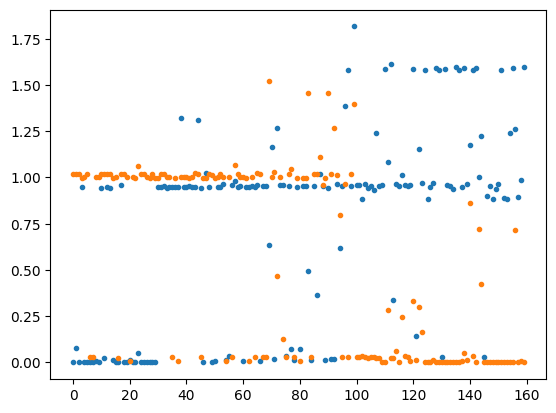

In [81]:
import matplotlib.pyplot as plt

idx = 20

plt.plot(
    compute_entropy_by_position(gene_idx_to_seq_arrays0[idx]), '.',
)
plt.plot(
    compute_entropy_by_position(gene_idx_to_seq_arrays1[idx]), '.',
)